<a href="https://colab.research.google.com/github/deckel28/music-mood/blob/master/mood_pred.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

In [ ]:
import os
import pickle
import h5py
import numpy as np
from numpy import savetxt
from numpy import genfromtxt
from numpy import random
from random import choices
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
from tensorflow import keras
import matplotlib.pyplot as plt
import csv

from keras import backend
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.layers import Conv2D, MaxPooling2D, LSTM, Dropout, BatchNormalization
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import fbeta_score
from sklearn.metrics import accuracy_score, hamming_loss
from sklearn.metrics import multilabel_confusion_matrix

In [ ]:
os.chdir('/content/drive/My Drive')
os.listdir()

In [ ]:
trainY = genfromtxt('Datasets/encoded_train.csv', delimiter=',')
h5f = h5py.File('Datasets/feats_train.h5','r')
trainX = h5f['dataset'][:]
h5f.close()

valY = genfromtxt('Datasets/encoded_val.csv', delimiter=',')
h5f = h5py.File('Datasets/feats_val.h5','r')
valX = h5f['dataset'][:]
h5f.close()

testY = genfromtxt('Datasets/encoded_test.csv', delimiter=',')
h5f = h5py.File('Datasets/feats_test.h5','r')
testX = h5f['dataset'][:]
h5f.close()

In [ ]:
print('trainX-', trainX.shape, '   trainY- ', trainY.shape)
print('valX-', valX.shape, '      valY- ', valY.shape)
print('testX-', testX.shape, '     testY- ', testY.shape)

trainX- (2802, 20, 9762)    trainY-  (2802, 8)
valX- (346, 20, 9762)       valY-  (346, 8)
testX- (312, 20, 9762)      testY-  (312, 8)


In [ ]:
trainX0 = np.expand_dims(trainX, axis=-1)
valX0 = np.expand_dims(valX, axis=-1)
testX0 = np.expand_dims(testX, axis=-1)

IN_SHAPE = trainX0.shape[1:]
print(IN_SHAPE)

(20, 9762, 1)


In [ ]:
print(trainX0.shape, valX0.shape, testX0.shape)
print(trainY.shape, valY.shape, testY.shape)

(2802, 20, 9762, 1) (346, 20, 9762, 1) (312, 20, 9762, 1)
(2802, 8) (346, 8) (312, 8)


In [ ]:
print(np.sum(trainY, axis=0))
print(np.sum(valY, axis=0))
print(np.sum(testY, axis=0))

[2444. 1220.    8.  873.  139.  638.   23.  338.]
[297. 157.   1. 101.  22.  85.   2.  45.]
[268. 151.   0.  78.  10.  73.   2.  36.]


In [ ]:
def fbeta(y_true, y_pred, beta=2):
  # clip predictions
  y_pred = backend.clip(y_pred, 0, 1)
  # calculate elements
  tp = backend.sum(backend.round(backend.clip(y_true * y_pred, 0, 1)), axis=1)
  fp = backend.sum(backend.round(backend.clip(y_pred - y_true, 0, 1)), axis=1)
  fn = backend.sum(backend.round(backend.clip(y_true - y_pred, 0, 1)), axis=1)
  # calculate precision
  p = tp / (tp + fp + backend.epsilon())
  # calculate recall
  r = tp / (tp + fn + backend.epsilon())
  # calculate fbeta, averaged across each class
  bb = beta ** 2
  fbeta_score = backend.mean((1 + bb) * (p * r) / (bb * p + r + backend.epsilon()))
  return fbeta_score

In [ ]:
def predict_mood(model, dataX, thresholds):
    predictions = model.predict(dataX)
    y_pred = np.zeros((dataX.shape[0], 8))
    for i in range(dataX.shape[0]):
        for j in range(8):
            y_pred[i][j] = (predictions[i][j] > thresholds[j][1])

    return y_pred, predictions

In [ ]:
def multilabel_cm(trues, preds):
    shape = trues.shape[0]
    cm = np.zeros((8, 8), dtype=int)
    for i in range(shape):
        for j in range(8):
            for k in range(8):
                if trues[i][j] == 1 and preds[i][k] == 1:
                    cm[j][k] = cm[j][k] + 1
    return cm

In [ ]:
def classification_report(trues, preds, thresholds, cm):
    fn = np.zeros((8,))
    fp = np.zeros((8,))
    tp = np.zeros((8,))
    print('CLASSIFICATION REPORT')
    print('---------------------')
    print(' ')

    cm = multilabel_cm(trues, preds)
    fps = np.sum(cm, axis=0)
    fns = np.sum(cm, axis=1)
    occ = np.sum(trues, axis=0)
    report = np.zeros((8, 4))

    for i in range(8):
        tp[i] = cm[i][i]
        fp[i] = fps[i] - cm[i][i]
        fn[i] = fns[i] - cm[i][i]

        precision = tp[i] / (tp[i] + fp[i])
        report[i][0] = precision
        recall = tp[i] / (tp[i] + fn[i])
        report[i][1] = recall
        f1score = 2 * precision * recall / (precision + recall)
        report[i][2] = f1score
        support = occ[i]
        report[i][3] = support

        print(thresholds[i][0])
        print('.....')
        print('Precision:', precision)
        print('Recall:', recall)
        print('F1-Score:', f1score)
        print('Support:', support)
        print('')
        print('')

    return report


In [ ]:
model = keras.models.load_model('Models/model1.h5')
# model.summary()

In [ ]:
thresholds = [['Happy', 0.8],
                ['Excited', 0.5],
                ['Frantic', 0.5],
                ['Anxious/Sad', 0.3],
                ['Anger', 0.5],
                ['Calm', 0.22],
                ['Tired', 0.5],
                ['Sensual', 0.1]]

tags = ['Happy', 'Excited', 'Frantic', 'Anxious/Sad', 'Anger', 'Calm', 'Tired', 'Sensual']

In [ ]:
accuracy = accuracy_score(trainY, y_pred)
print('Accuracy: %f' % accuracy)

f1 = fbeta(trainY, y_pred)
print('F1 score: %f' % f1)

hl = hamming_loss(trainY, y_pred)
print('Hamming Loss: %f' % hl)

In [ ]:
y_pred, y_pred_val = predict_mood(model, trainX0, thresholds)
cm = multilabel_cm(trainY, y_pred.astype(np.float))
report = classification_report(trainY, y_pred.astype(np.float), thresholds, cm)

In [ ]:
tags1 = np.array(tags).reshape((1, 8))
y_pred1 = np.vstack((tags1, y_pred))
print(y_pred1)

[['Happy' 'Excited' 'Frantic' ... 'Calm' 'Tired' 'Sensual']
 ['1.0' '1.0' '0.0' ... '0.0' '0.0' '0.0']
 ['1.0' '0.0' '0.0' ... '1.0' '0.0' '0.0']
 ...
 ['1.0' '0.0' '0.0' ... '0.0' '0.0' '0.0']
 ['0.0' '1.0' '0.0' ... '1.0' '0.0' '0.0']
 ['1.0' '0.0' '0.0' ... '0.0' '0.0' '0.0']]


In [ ]:
cm1 = np.vstack((tags, cm))
print('-------- Confusion Matrix-----------')
print(cm1)
savetxt('Results/cm.csv', cm1, delimiter=',', fmt='%s')

In [ ]:
report = np.vstack((['Precision', 'Recall', 'F1-Score', 'Support'], report))
x = np.array(thresholds)
names = np.append(['Label'], x[:, 0])
names = names.reshape(9, 1)
report = np.hstack((names, report))
print(report)
savetxt('Results/report.csv', report, delimiter=',', fmt='%s')

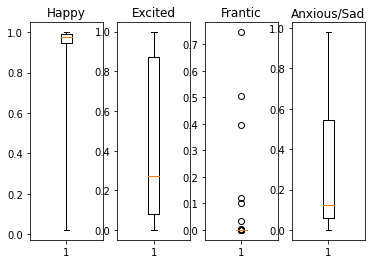

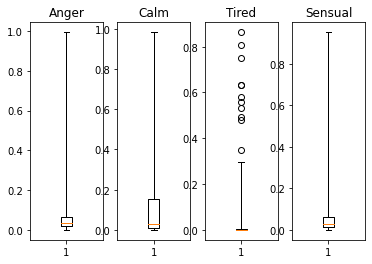

In [ ]:
for x in range(2):
    fig, axs = plt.subplots(1, 4)
    for i in range(4):
        axs[i].boxplot(y_pred_val[1:, i + 4 * x].astype(np.float), whis=100)
        axs[i].set_title(thresholds[i + 4 * x][0])
    plt.savefig('Results/train_box_' + str(x) + '.png')